## Bitcoin Volatility Prediction

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
import os

### Loading Data

In [22]:
df = pd.read_csv('../data/BIT_2023_1차.csv')
df.set_index('time', inplace=True)
df.index=pd.to_datetime(df.index)

In [24]:
df.isnull().sum()

Open               24
High               24
Low                24
Close              24
Volume              0
returns            12
volatility        186
price              24
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

### Checking Missing Value
- 결측치 처리 방법 논의 필요(fillna(method = 'ffill'), 선형보간 등등)
- price(ohlc) : 특정일자 01/25 (16~23시까지 결측값), 대부분 결측치가 연속형
- r : 해당 month의 1일 계산에 포함x
- v : window 값 만큼 계산에 포함x

In [31]:
df[df['Open'].isnull()].index #price

DatetimeIndex(['2023-01-23 21:00:00', '2023-01-23 22:00:00',
               '2023-01-23 23:00:00', '2023-01-24 21:00:00',
               '2023-01-24 22:00:00', '2023-01-24 23:00:00',
               '2023-01-25 16:00:00', '2023-01-25 17:00:00',
               '2023-01-25 18:00:00', '2023-01-25 19:00:00',
               '2023-01-25 20:00:00', '2023-01-25 21:00:00',
               '2023-01-25 22:00:00', '2023-01-25 23:00:00',
               '2023-01-26 22:00:00', '2023-01-26 23:00:00',
               '2023-03-14 23:00:00', '2023-03-15 22:00:00',
               '2023-03-15 23:00:00', '2023-11-21 03:00:00',
               '2023-11-21 04:00:00', '2023-11-21 05:00:00',
               '2023-11-21 06:00:00', '2023-11-21 07:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

### Technical Indicators
- (논의)windows, period 통일 필요

#### MACD Function
Short-term Moving Average (Short MA): Indicates recent price trends in the stock.
Long-term Moving Average (Long MA): Represents long-term trends in the stock.
MACD Indicator: The difference between the short-term and long-term moving averages, revealing the disparity in short and long-term trends.
Signal Line: The moving average of the MACD, signaling potential trend reversals.
MACD Oscillator: The difference between the MACD and the Signal Line, used to identify buying or selling points.
#### Stochastic Oscillator Function
%K: Represents the current position of the stock price within a certain period, expressed as a percentage. Measures the relative position of the stock price.
%D: The moving average of %K, indicating the average position of the stock price.
Stochastic Oscillator: Identifies overbought or oversold conditions based on the relative position of the stock price.
#### ATR Function
True Range: A measure of stock volatility, calculated as the maximum of the high-low range, high-close difference, and low-close difference.
ATR (Average True Range): The moving average of the True Range, representing the expected volatility of the stock.
#### Bollinger Bands Function
Moving Average: Computes the average stock price over a specific period.
Standard Deviation: Indicates the volatility of the stock price.
Upper and Lower Bollinger Bands: Calculated by adding or subtracting a multiple of the standard deviation from the moving average. Represents the relative high or low positions of the stock price.

In [13]:
# MACD 함수
def MACD(df, short_window, long_window, signal_window):
    
    df[f'Short_MA_{short_window}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'Long_MA_{long_window}'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df[f'MACD_{short_window}{long_window}'] = df[f'Short_MA_{short_window}'] - df[f'Long_MA_{long_window}']
    df[f'Signal_Line_{signal_window}'] = df[f'MACD_{short_window}{long_window}'].ewm(span=signal_window, adjust=False).mean()
    df[f'MACD_Oscillator{short_window}{long_window}'] = df[f'MACD_{short_window}{long_window}'] - df[f'Signal_Line_{signal_window}']
    
# Stochastic Oscillator 함수
def cal_stoc_os(df, period=14, m=3): # period = 14 or 20
    
    # 최근 N일간의 최고가(H)와 최저가(L)
    df['highest_high'] = df['High'].rolling(window=period).max()
    df['lowest_low'] = df['Low'].rolling(window=period).min()
    
    # %K 계산
    df['%K'] = (df['Close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low']) * 100
    
    # %D 계산
    df['%D'] = df['%K'].rolling(m).mean()
    
# ATR 함수
def calculate_atr(df, period=14):
    # True Range 계산
    df['high-low'] = df['High'] - df['Low']
    df['high-close'] = abs(df['High'] - df['Close'].shift())
    df['low-close'] = abs(df['Low'] - df['Close'].shift())
    
    df['true_range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)
    
    # ATR 계산
    df['atr'] = df['true_range'].rolling(window=period, min_periods=1).mean()
    
    # 임시 열 삭제
    df.drop(['high-low', 'high-close', 'low-close', 'true_range'], axis=1, inplace=True)

def bollinger_bands(df, window=20, num_std_dev=2):
    
    # 이동평균 계산
    df['rolling_mean'] = df['price'].rolling(window=window).mean()

    # 표준편차 계산
    df['rolling_std'] = df['price'].rolling(window=window).std()

    # 볼린저 밴드 상단 및 하단 계산
    df['upper_band'] = df['rolling_mean'] + (num_std_dev * df['rolling_std'])
    df['lower_band'] = df['rolling_mean'] - (num_std_dev * df['rolling_std'])

    # 필요없는 컬럼 삭제
    df.drop(['rolling_mean', 'rolling_std'], axis=1, inplace=True)


In [14]:
MACD(df, 6, 13, 4) # 단기추세 감지 but 노이즈에 민감할 가능성 있음
MACD(df, 12, 26, 9) # 일반적인 window 계수 but 변동성이 큰 시장에선 느리게 반응할 수 있음
calculate_atr(df)
cal_stoc_os(df)
bollinger_bands(df)

In [15]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'volatility',
       'price', 'quote_qty', 'is_buyer_maker', 'quote_qty_cal', 'Short_MA_6',
       'Long_MA_13', 'MACD_613', 'Signal_Line_4', 'MACD_Oscillator613',
       'Short_MA_12', 'Long_MA_26', 'MACD_1226', 'Signal_Line_9',
       'MACD_Oscillator1226', 'atr', 'highest_high', 'lowest_low', '%K', '%D',
       'upper_band', 'lower_band'],
      dtype='object')

In [16]:
df.shape

(8760, 28)

In [17]:
df.describe()

,Open,High,Low,Close,Volume,returns,volatility,price,quote_qty,is_buyer_maker,...,MACD_1226,Signal_Line_9,MACD_Oscillator1226,atr,highest_high,lowest_low,%K,%D,upper_band,lower_band
count,8736.000000,8736.000000,8736.000000,8736.000000,8760.000000,8748.000000,8574.000000,8736.000000,8736.000000,8.760000e+03,...,8760.000000,8760.000000,8760.000000,8760.000000,8632.000000,8632.000000,8632.000000,8616.000000,8587.000000,8587.000000
mean,28804.130540,28891.935085,28716.037191,28807.059467,17056.460292,0.000118,0.003896,28805.170679,12658.709880,7.182958e+04,...,20.789249,20.754829,0.034420,175.816296,29205.090222,28474.299687,51.494071,51.495582,29211.261972,28495.414666
std,5888.434989,5908.192988,5867.904464,5888.802865,20699.978444,0.004563,0.002423,5888.087791,4405.138976,6.862010e+04,...,151.151588,143.025837,43.719527,98.277824,5945.194931,5785.911663,23.148779,21.070010,5937.038751,5794.203094
min,16504.300000,16524.900000,16488.000000,16504.200000,0.000000,-0.062584,0.000453,16511.345482,4234.220298,0.000000e+00,...,-620.169040,-552.435958,-204.256973,15.371429,16565.900000,16488.000000,0.000000,6.166357,16590.822650,16486.667193
25%,25921.375000,25991.775000,25860.850000,25922.600000,6064.877750,-0.001524,0.002256,25920.714877,9637.500304,3.164950e+04,...,-45.889499,-42.945911,-19.228752,108.364286,26199.000000,25749.500000,32.572813,34.469481,26192.503870,25762.338303
50%,27708.550000,27821.450000,27622.150000,27710.050000,10470.787500,0.000071,0.003361,27718.307235,11621.437472,5.102250e+04,...,6.093954,6.053262,-0.453125,157.767857,28127.950000,27307.000000,51.306021,51.560209,28117.224641,27372.986889
75%,30276.050000,30332.700000,30221.850000,30276.250000,19544.913500,0.001705,0.004896,30277.162765,14655.969788,8.682075e+04,...,70.832747,68.157391,18.025519,221.616071,30560.000000,29928.800000,70.121780,68.311779,30541.231468,30013.568431
max,44572.000000,44779.300000,44265.700000,44572.000000,355275.447000,0.055638,0.020826,44522.957160,53959.792130,1.133635e+06,...,1027.780514,914.341985,343.236749,950.978571,44779.300000,43754.100000,99.935284,96.268521,45049.681113,43759.153847


In [19]:
rows_with_nan = df[df.isnull().any(axis=1)]

print("Rows with NaN values:")
print(rows_with_nan)

Rows with NaN values:
                        Open     High      Low    Close     Volume   returns  \
time                                                                           
2023-01-01 00:00:00  16537.5  16540.9  16504.0  16527.0   5381.399       NaN   
2023-01-01 01:00:00  16527.1  16554.3  16524.1  16550.4   3210.826  0.001416   
2023-01-01 02:00:00  16550.5  16557.1  16534.8  16542.4   2399.668 -0.000483   
2023-01-01 03:00:00  16542.5  16542.5  16515.0  16529.3   3214.480 -0.000792   
2023-01-01 04:00:00  16529.2  16530.4  16508.8  16517.8   3150.954 -0.000696   
...                      ...      ...      ...      ...        ...       ...   
2023-12-01 15:00:00  38315.7  38438.8  38280.7  38401.5   9318.683  0.002239   
2023-12-01 16:00:00  38401.4  38989.0  38383.0  38790.0  48700.511  0.010117   
2023-12-01 17:00:00  38790.1  38880.0  38689.3  38787.1  14196.141 -0.000075   
2023-12-01 18:00:00  38787.1  38920.9  38685.2  38691.7  10926.704 -0.002460   
2023-12-01 19:00:0

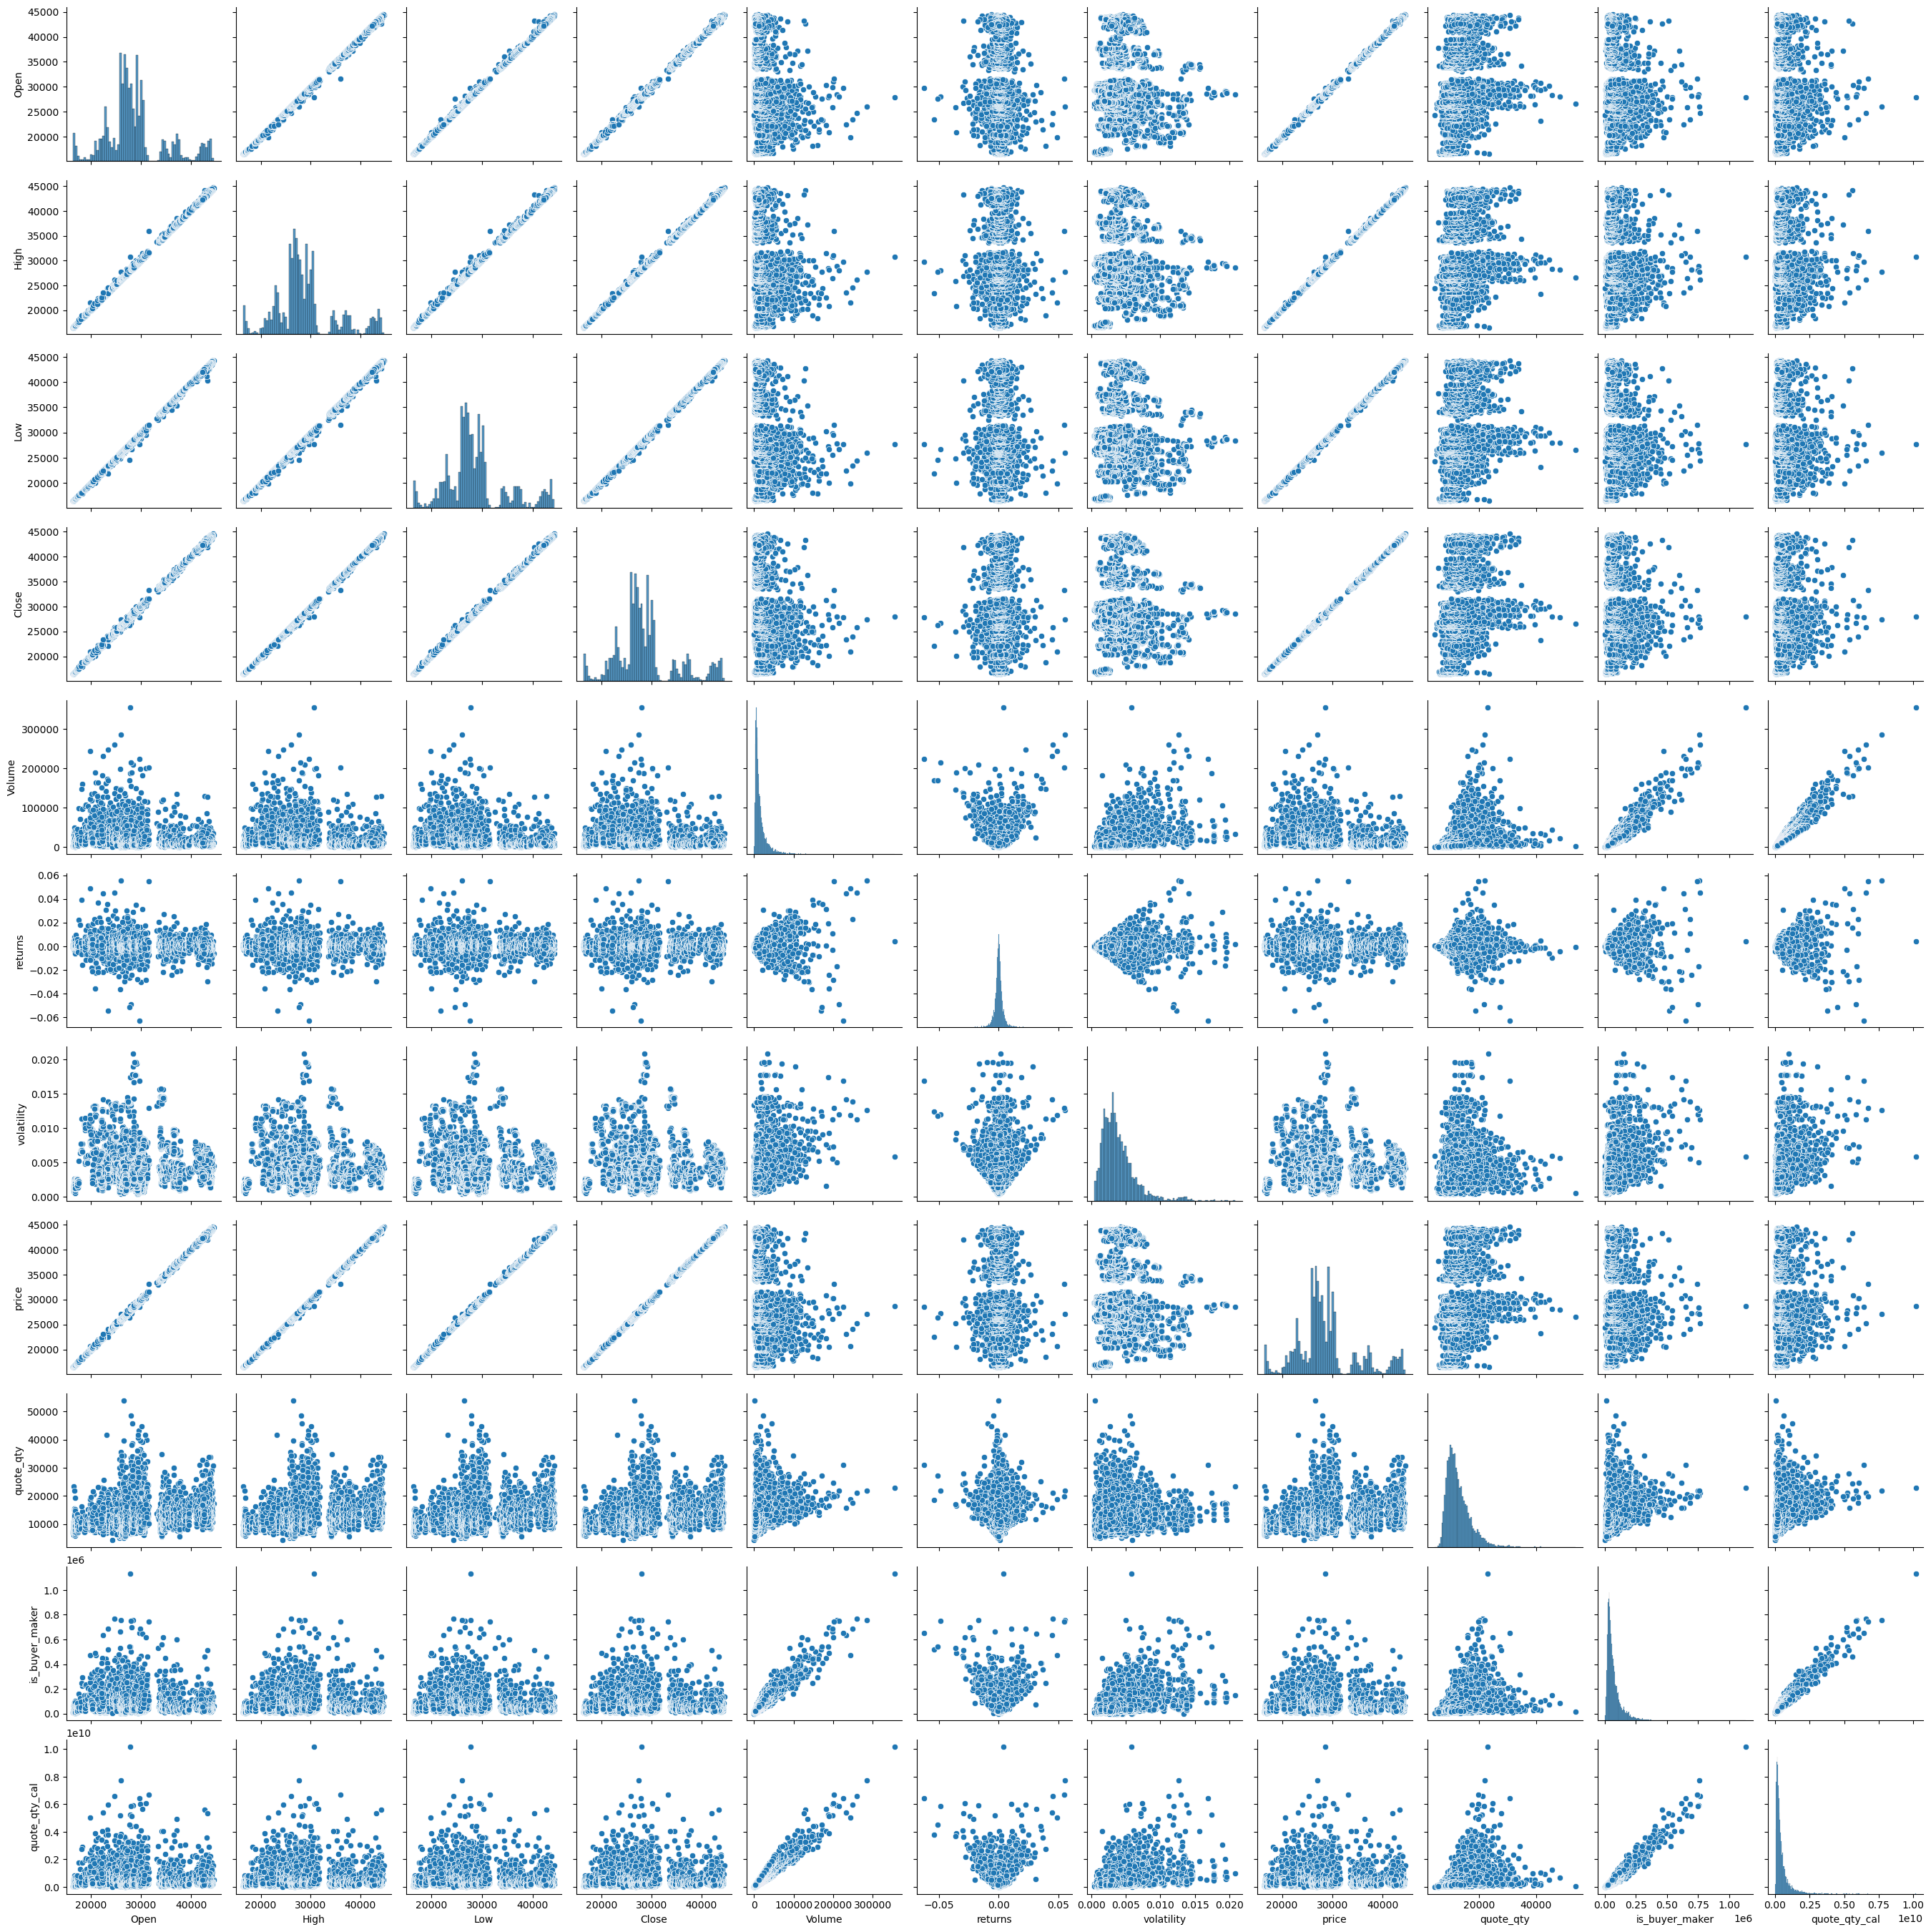

In [33]:
ax = sns.pairplot(df)